# Code for AMAS project 1
### *By Niels August Davidsen*

In [430]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

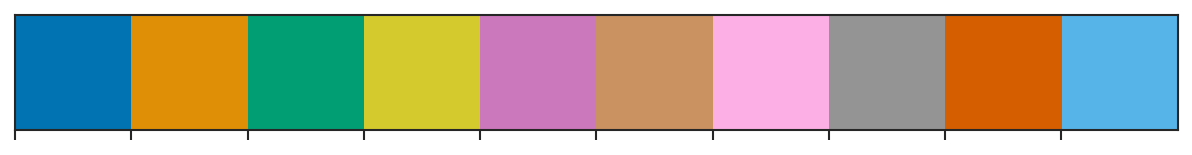

In [431]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.color_palette('colorblind', 10, desat = 1)
# Swap colors 2 and -2
colors[3], colors[-2] = colors[-2], colors[3]
# Darken color 3
colors[3] = tuple(np.array(colors[3]) * 0.9)

#colors = colors[::-1]
#colors.pop(2)
sns.set_palette(colors)
sns.palplot(colors)

# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.grid.axis'] = 'y'
# plt.rcParams['axes.grid.which'] = 'major'
# plt.rcParams['grid.linestyle'] = '--'
# plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
# plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [432]:
url_2014 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2014KenPomeroy.html'
url_2009 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2009KenPomeroy.html'


def scrape_table(url):
    
    # Send a GET request to the webpage
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Parse the webpage content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table using soup (BS4) - Table id is found by inspecting the HTML file of the webpage
    table = soup.find('table', {'id': 'ratings-table'})

    # Extract table headers
    headers = [th.get_text() for th in table.find('thead').find_all('th')]
    headers = list(filter(lambda x: x != '', headers))
    headers = headers[2:]


    for j in range(4):
        if j == 0:
            headers[-(j + 1)] = headers[-(j + 1)] + '_NCOS'
        else:
            headers[-(j + 1)] = headers[-(j + 1)] + '_SoS'


    # Finding strings with ONLY integers of length 1, 2 or 3
    pattern = re.compile(r'^\d{1,3}$')
    reg_city = re.compile(r'\d{1,2}$')

    # Extract table rows
    rows = []
    for row_number,row in enumerate(table.find('tbody').find_all('tr')):
        cells = row.find_all(['th', 'td'])
        cells_text = [cell.get_text() for cell in cells]

        if cells_text[0] == '' or cells_text[0] == ' ' or re.search(r'\d$', cells_text[0]) is None:
            continue
        
        # Remove elements in cells_text that concists ONLY of integers of length 1, 2 or 3
        for i, element in enumerate(cells_text):

            if pattern.match(element) and i > 1:
                cells_text.pop(i)

        reg_search = reg_city.search(cells_text[1])
        if reg_search is not None:
            cells_text[1] = cells_text[1][:- ( len(reg_search.group(0) ) + 1 )]

        # Creating an fail-safe for the case where the length of cells_text does not match the length of headers
        if len(cells_text) != len(headers):
            print(len(cells_text), len(headers))
            print(f'Error: Length of cells_text does not match length of headers in row {row_number}')

        rows.append(cells_text)
    
    return pd.DataFrame(rows, columns=headers)


In [433]:

df_2014 = scrape_table(url_2014)                                # Create a DataFrame from the rows
df_2014.to_csv('kenpom_2014_ratings.csv', index=False)                       # Save the DataFrame to a CSV file

In [434]:
# Read df using pandas html reader (ALTERNATIVE METHOD) - This method is WAY faster, but leaves in some unwanted data
df_2014_pd = pd.read_html(url_2014, header=17)[0]

# Remove numbers from the team names
df_2014_pd['Team'] = df_2014_pd['Team'].str.replace(r'\d+', '')
df_2014_pd['Team'] = df_2014_pd['Team'].str.strip()

#display(df_2014_pd)                                                      # Display the DataFrame

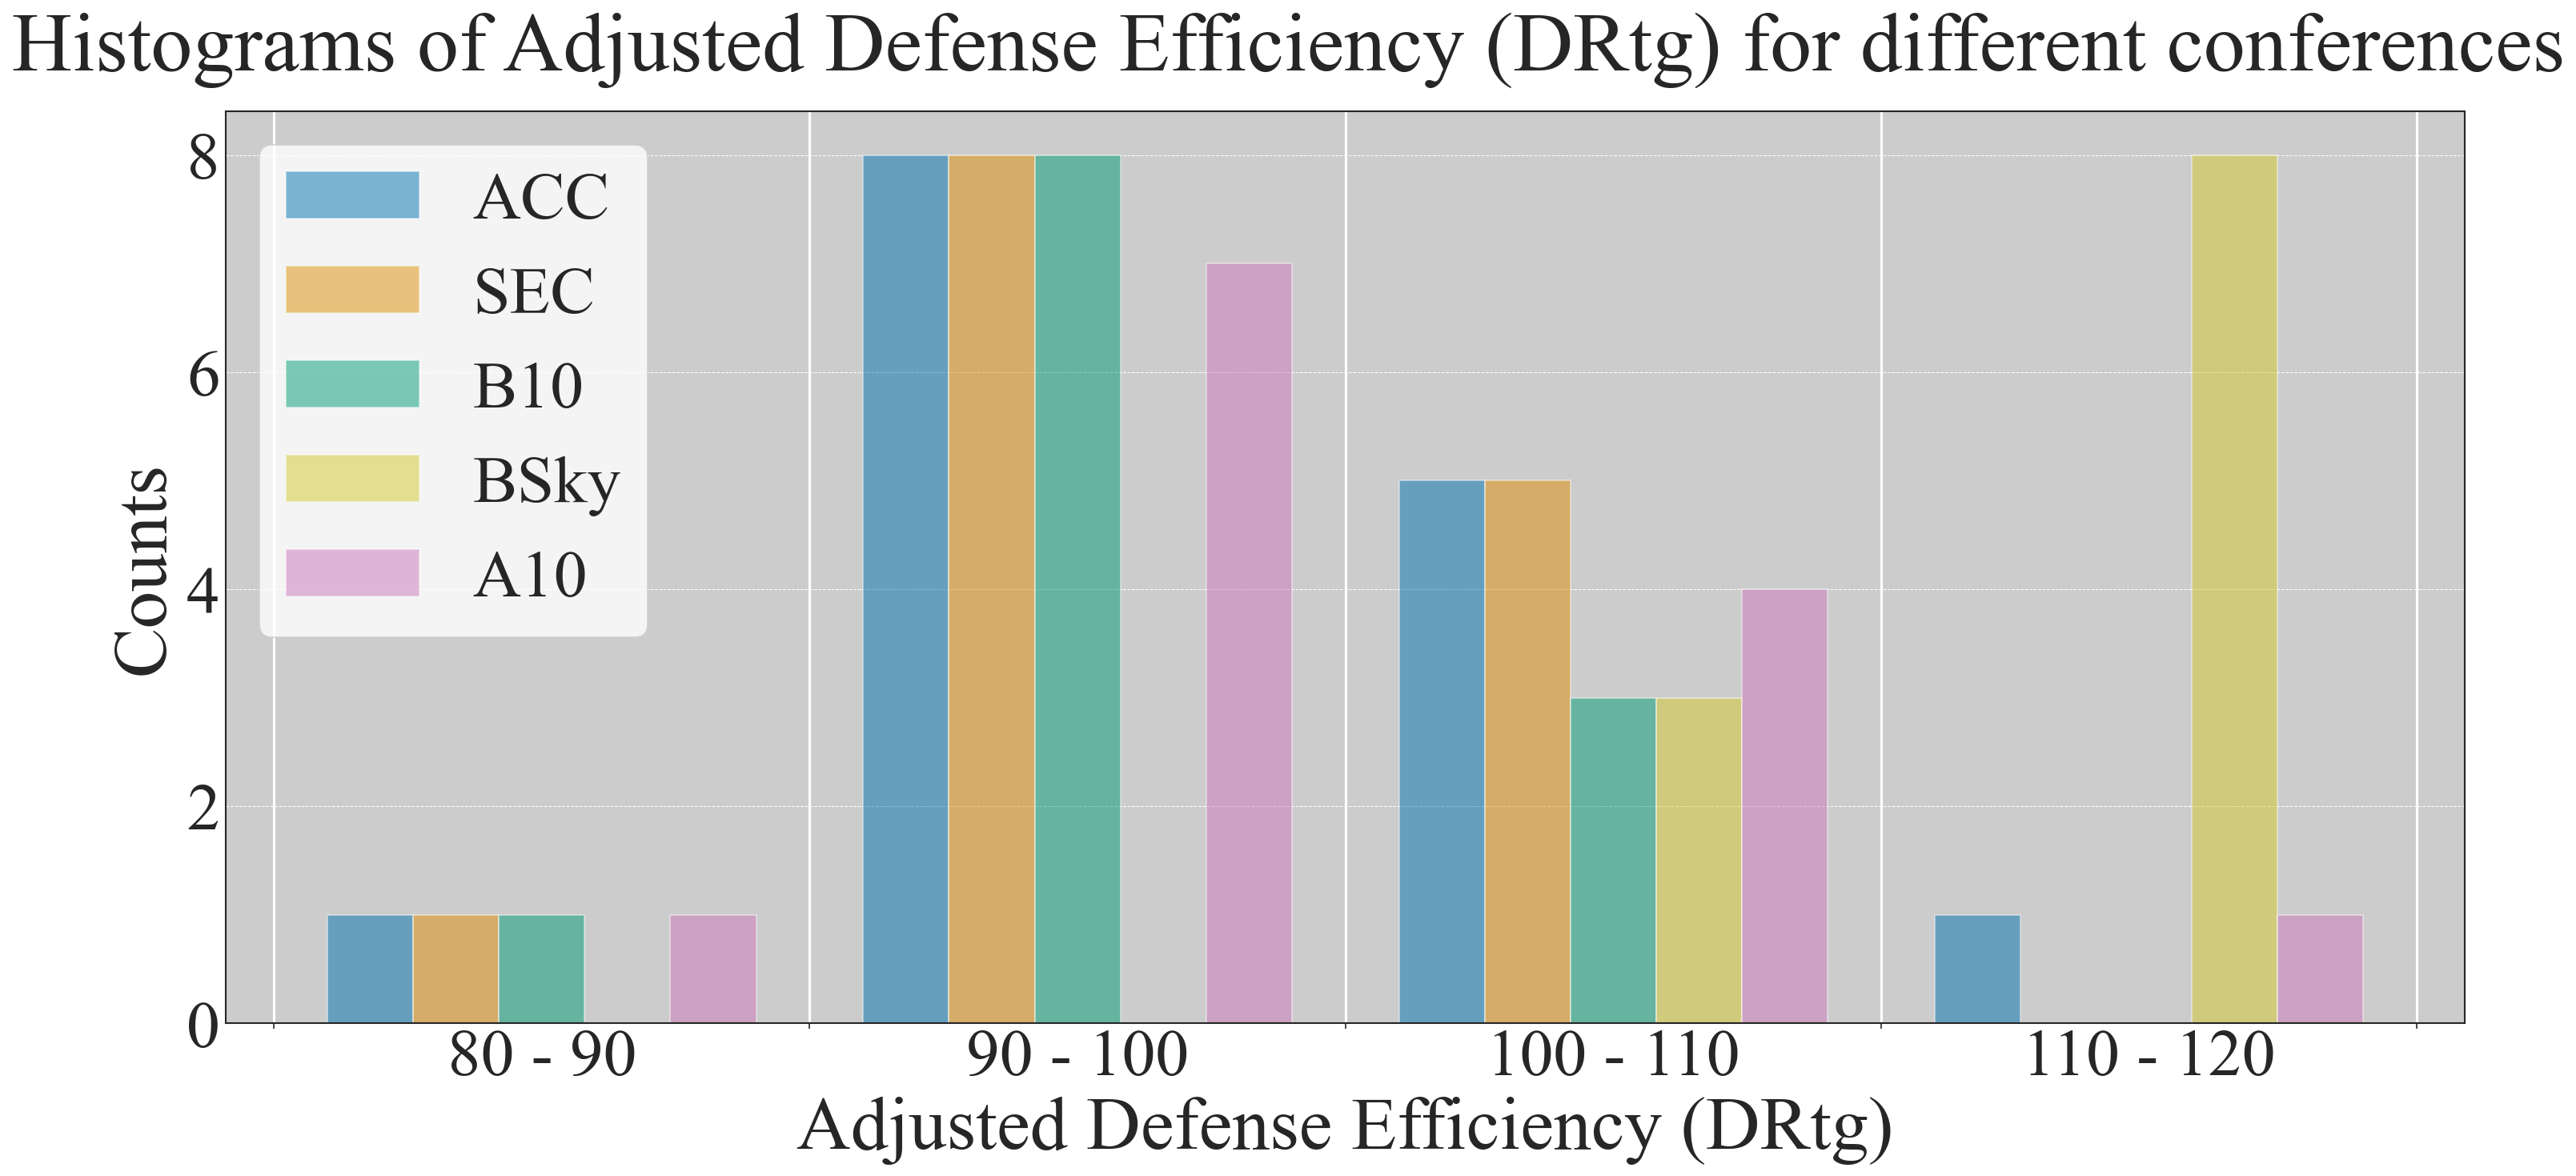

In [435]:
# Grouping the data into conferences (ACC, SEC, B10, BSky and A10)

conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)

def plot_hist(conf_names, bin_arr, hist_range):
    hist_data = []
    bin_centers = bin_arr[:-1] + np.diff(bin_arr) / 2

    for i, conf in enumerate(conf_names):
        conf_teams = df_2014[df_2014['Conf'] == conf]
        hist_data.append(conf_teams['DRtg'].astype(float))

    fig_conf, ax_conf = plt.subplots(1, 1, figsize=(20, 10), dpi = 150)



    ax_conf.hist(hist_data, range=hist_range, bins=bin_arr, alpha=0.5, label=conf_names, color = colors[:len(conf_names)])
    fig_conf.suptitle('Histograms of Adjusted Defense Efficiency (DRtg) for different conferences', fontsize=50, )
    

    ax_conf.set_xlabel('Adjusted Defense Efficiency (DRtg)', fontsize=45)
    ax_conf.set_ylabel('Counts', fontsize=45)


    ax_conf.grid(visible=True, which='major', axis='y', color = 'white', linestyle='--', linewidth=0.5)  # Grid on bin edges
    explanatory_labels = [f"{bin_arr[i]} - {bin_arr[i+1]}" for i in range(len(bin_arr) - 1)]
    ax_conf.set_xticks(bin_centers, explanatory_labels)
    ax_conf.tick_params(length=0, labelsize=40)




    # Set grid at bin edges
    ax_conf.set_xticks(bin_arr, minor=True)  # Set grid at bin edges
    ax_conf.grid(visible=True, which='minor', axis='x', color='white', linestyle='-', linewidth=1.5)  # Grid on bin edges
    ax_conf.set_facecolor('0.8')

    ax_conf.legend(loc='upper left', fontsize=40)

    fig_conf.tight_layout()

    return fig_conf, ax_conf
    
fig_conf, ax_conf = plot_hist(conf_names, bin_arr, hist_range)
plt.savefig('figures/hist1.png', bbox_inches='tight')

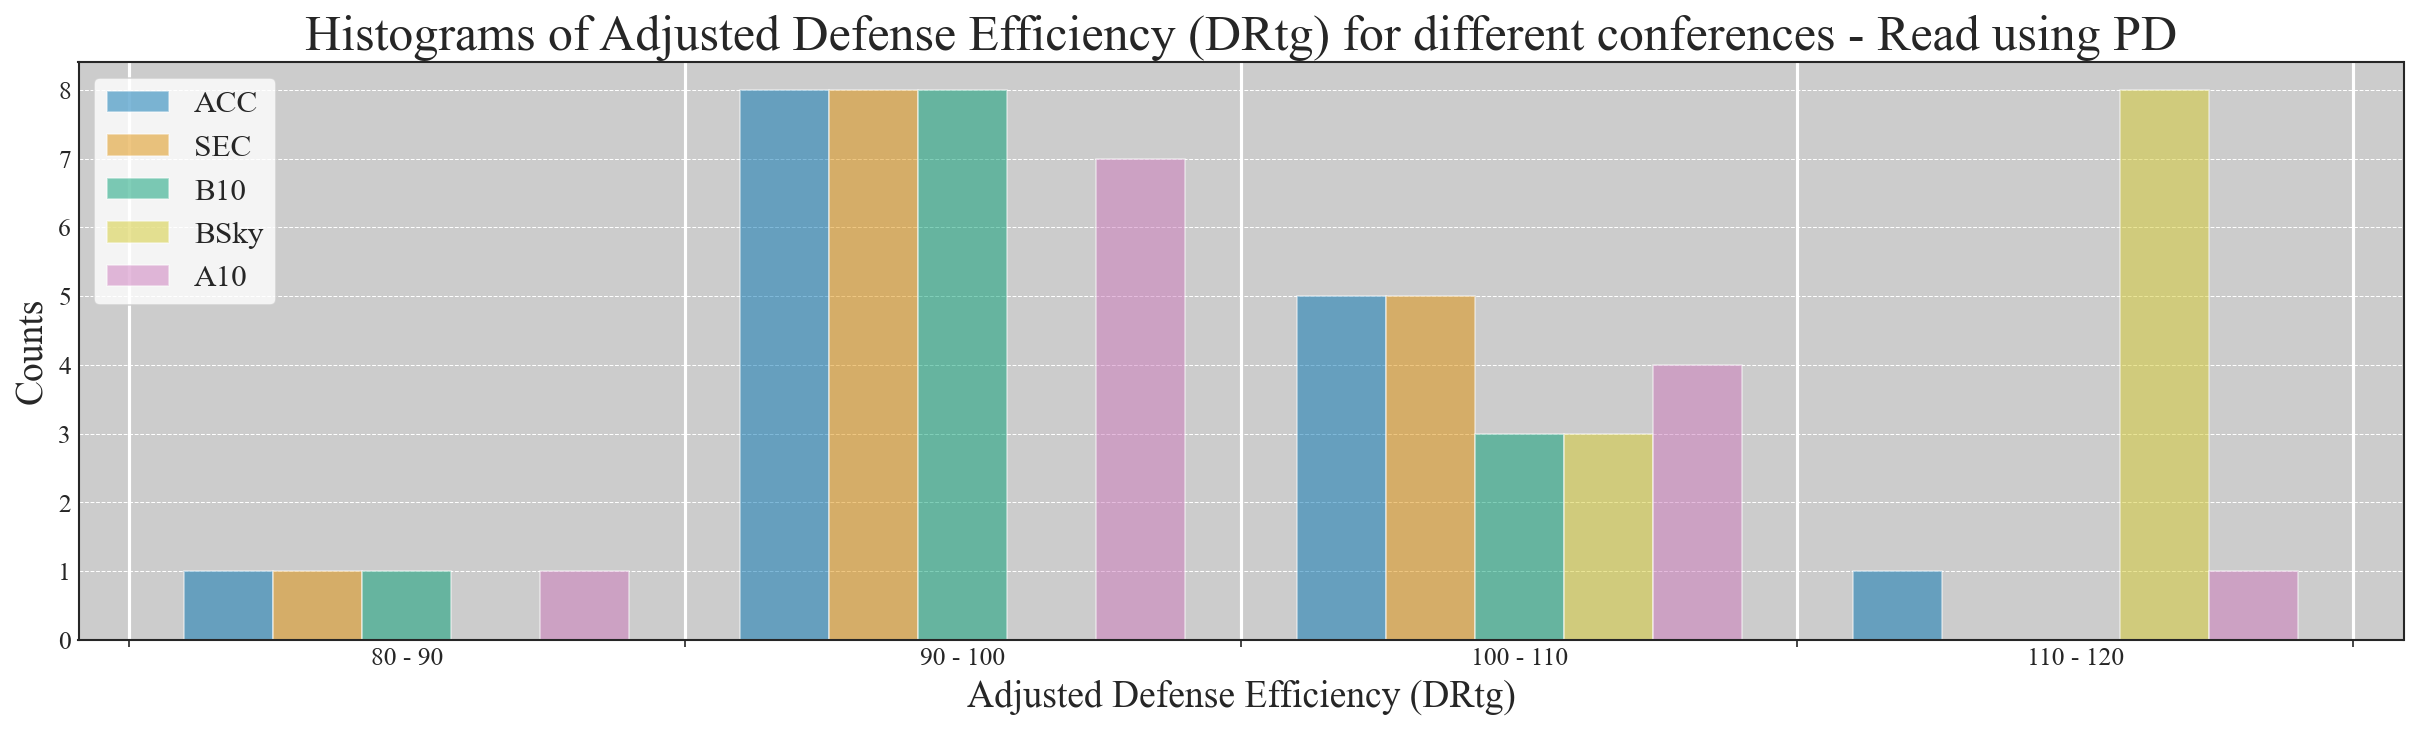

In [436]:
# Same plot for the 2014 data read by pandas
fig_conf_pd, ax_conf_pd = plt.subplots(1, 1, figsize=(20, 5), dpi = 150)
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)
bin_centers = bin_arr[:-1] + np.diff(bin_arr) / 2

hist_data_pd = []
for i, conf in enumerate(conf_names):
    conf_teams = df_2014_pd[df_2014_pd['Conf'] == conf]
    hist_data_pd.append(conf_teams['DRtg'].astype(float))

ax_conf_pd.hist(hist_data_pd, range=hist_range, bins=bin_arr, alpha=0.5, label=conf_names, color = colors[:len(conf_names)])
ax_conf_pd.set_title('Histograms of Adjusted Defense Efficiency (DRtg) for different conferences - Read using PD', fontsize=24)
ax_conf_pd.set_xlabel('Adjusted Defense Efficiency (DRtg)', fontsize=18)
ax_conf_pd.set_ylabel('Counts', fontsize=18)

ax_conf_pd.grid(visible=True, which='major', axis='y', color = 'white', linestyle='--', linewidth=0.5)  # Grid on bin edges
explanatory_labels = [f"{bin_arr[i]} - {bin_arr[i+1]}" for i in range(len(bin_arr) - 1)]
ax_conf_pd.set_xticks(bin_centers, explanatory_labels)
ax_conf_pd.tick_params(length=0)

# Set grid at bin edges
ax_conf_pd.set_xticks(bin_arr, minor=True)  # Set grid at bin edges
ax_conf_pd.grid(visible=True, which='minor', axis='x', color='white', linestyle='-', linewidth=1.5)  # Grid on bin edges
ax_conf_pd.set_facecolor('0.8')

ax_conf_pd.legend(loc='upper left', fontsize=15)


_____

In [437]:
df_2009 = scrape_table(url_2009)                                # Create a DataFrame from the rows
df_2009.to_csv('kenpom_2009_ratings.csv', index=False)                       # Save the DataFrame to a CSV file

for i, value in enumerate(df_2009['ORtg']):
    if re.search(r'\d', value) == None:
        print(i, value)


In [438]:
# Read in the data using pandas html reader (ALTERNATIVE METHOD) - This method is WAY faster, but leaves in some unwanted data
df_2009_pd = pd.read_html('2009_data.htm', header=17)[0]

# Remove all numbers in the team names
df_2009_pd['Team'] = df_2009_pd['Team'].str.replace('\d+', '')
df_2009_pd['Team'] = df_2009_pd['Team'].str.strip()

# Display the DataFrame
# display(df_2009_pd)

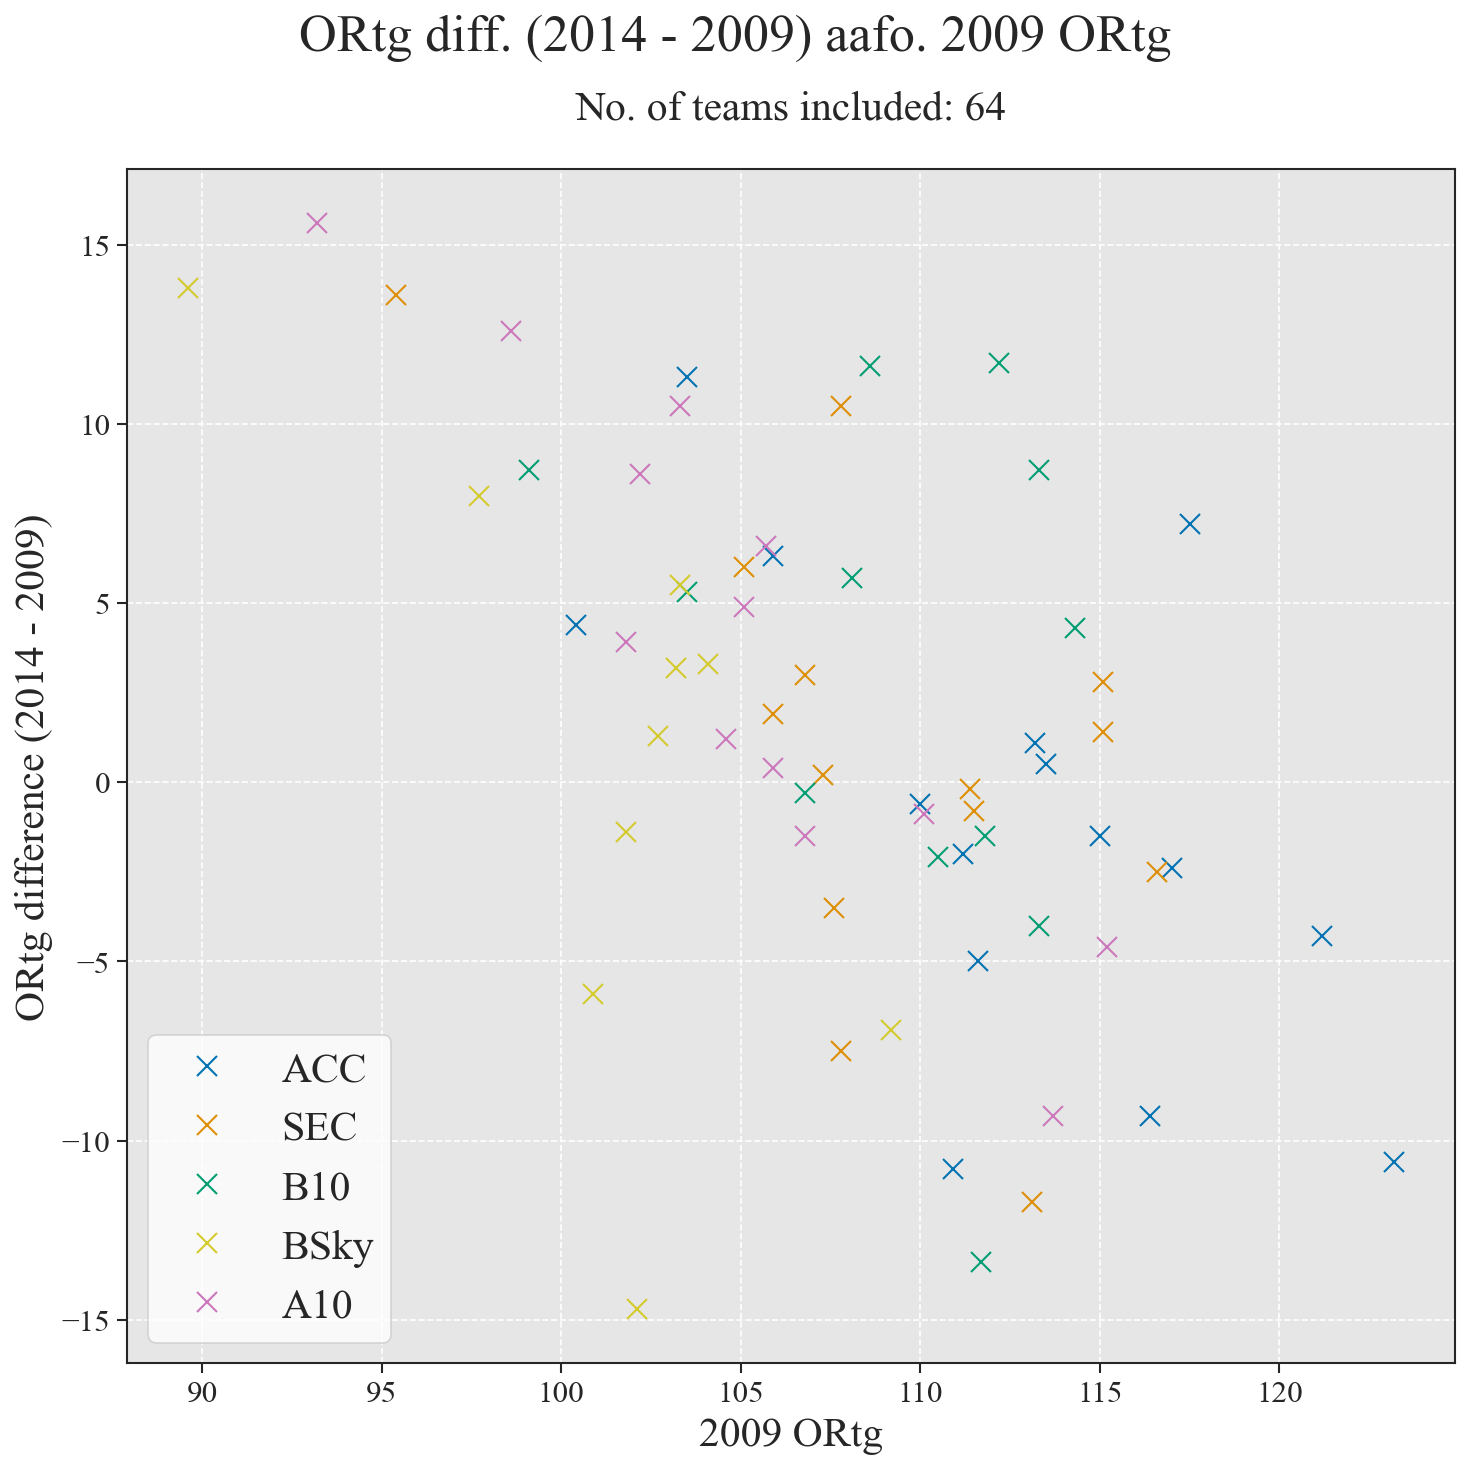

In [439]:
# Grouping the data into conferences (ACC, SEC, B10, BSky and A10)

conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']

def diff_extractor(conf_names):

    non_inc_teams = pd.DataFrame(columns=['Conf in 2014','Team Name'])

    ORtg_diff_collection = []
    ORtg_2009_collection = []

    for i, conf in enumerate(conf_names):
        ORtg_2009 = []
        ORtg_diff = []

        conf_teams_2014 = df_2014[df_2014['Conf'] == conf].copy()
        conf_teams_2014['ORtg'] = conf_teams_2014['ORtg'].astype(float)

        for team in conf_teams_2014['Team']:
            if team not in df_2009['Team'].values:
                #print(f'Team {team} is not in the 2009 data')
                not_in_2009_row = {'Conf in 2014': conf, 'Team Name': team}
                non_inc_teams = non_inc_teams._append(not_in_2009_row, ignore_index=True)
            else: 
                diff = conf_teams_2014[conf_teams_2014['Team'] == team]['ORtg'].values - df_2009[df_2009['Team'] == team]['ORtg'].values.astype(float)
                ORtg_diff.append(diff[0])
                ORtg_2009.append(float(df_2009[df_2009['Team'] == team]['ORtg'].values[0]))


        ORtg_diff_collection.append(ORtg_diff)
        ORtg_2009_collection.append(ORtg_2009)

    return ORtg_diff_collection, ORtg_2009_collection, non_inc_teams.copy()

def diff_plot(conf_names, ortg_diff, ortg_old, inc_text=False):
    fig_diff, ax_diff = plt.subplots(1, 1, figsize=(10, 10), dpi = 150)

    for i, conf in enumerate(conf_names):
        ax_diff.plot(ortg_old[i], ortg_diff[i], 'x', markersize=10, label= conf, color=colors[i])

    if inc_text:
        ax_diff.text(0.5, 1.1, f"Including conference 'BE'", transform=ax_diff.transAxes, fontsize=20, va='center', ha='center')

    len_list = [len(ortg_diff[i]) for i in range(len(ortg_diff))]
    ax_diff.text(0.5, 1.05, f'No. of teams included: {sum(len_list)}', transform=ax_diff.transAxes, fontsize=20, va='center', ha='center')
    ax_diff.legend(fontsize=20, loc='lower left')
    fig_diff.suptitle('ORtg diff. (2014 - 2009) aafo. 2009 ORtg', fontsize=25, )
    ax_diff.set_xlabel('2009 ORtg', fontsize=20)
    ax_diff.set_ylabel('ORtg difference (2014 - 2009)', fontsize=20)
    ax_diff.grid(visible=True, which='major', axis='both', color='white', linestyle='--', linewidth=0.8)
    ax_diff.set_facecolor('0.9')
    ax_diff.tick_params( labelsize=15)

    fig_diff.tight_layout()

    return fig_diff, ax_diff

def ortg_data_extr(conf_names, ortg_diff, non_inc_teams):


    conf_diff = pd.DataFrame(columns=['Conference', '# teams', 'Median ORtg diff', 'Mean ORtg diff'])

    for i, conf in enumerate(conf_names):
        ORtg_series = pd.Series(ortg_diff[i].copy())

        # Joining together a new dataframe with the columns: Conference, # teams, median diff, mean diff
        new_row = {'Conference': conf, '# teams': len(ORtg_series), 'Median ORtg diff': ORtg_series.median(), 'Mean ORtg diff': ORtg_series.mean().round(2)}

        # Checking if the median or mean of the ORtg difference is NaN
        if np.isnan(new_row['Median ORtg diff']) or np.isnan(new_row['Mean ORtg diff']):
            print('NaN value in Median or Mean ORtg diff')
        else:
            conf_diff = conf_diff._append(new_row, ignore_index=True)


    other_conf = 'Other conf.'
    conf_teams_2014_other = df_2014[~df_2014['Conf'].isin(conf_names)].copy()
    conf_teams_2014_other['ORtg'] = conf_teams_2014_other['ORtg'].astype(float)

    ORtg_diff_other = []

    for team in conf_teams_2014_other['Team']:
        if team not in df_2009['Team'].values:
            conf_team_str = 'Other Conf (' + conf_teams_2014_other[conf_teams_2014_other['Team'] == team]['Conf'].values + ')'
            not_in_2009_row = {'Conf in 2014': conf_team_str[0], 'Team Name': team}
            non_inc_teams = non_inc_teams._append(not_in_2009_row, ignore_index=True)
            # print(f'Team {team} is not in the 2009 data')
        else: 
            diff = conf_teams_2014_other[conf_teams_2014_other['Team'] == team]['ORtg'].values - df_2009[df_2009['Team'] == team]['ORtg'].values.astype(float)
            ORtg_diff_other.append(diff[0])
    
    ORtg_series_other = pd.Series(ORtg_diff_other.copy())
    new_row = {'Conference': other_conf, '# teams': len(ORtg_series_other), 'Median ORtg diff': ORtg_series_other.median(), 'Mean ORtg diff': ORtg_series_other.mean().round(2)}
    conf_diff = conf_diff._append(new_row, ignore_index=True)


    return conf_diff, non_inc_teams


ortg_diff, ortg_old, non_inc_teams = diff_extractor(conf_names)
fig_diff, ax_diff = diff_plot(conf_names, ortg_diff, ortg_old)

plt.savefig('figures/diff_plot1.png', bbox_inches='tight')

In [440]:
# Grouping data of conferences not in conf names

conf_diff, non_inc_teams_updated = ortg_data_extr(conf_names, ortg_diff, non_inc_teams)
display(conf_diff)
print(conf_diff.to_latex(index=False))
display(non_inc_teams_updated)
print(non_inc_teams_updated.to_latex(index=False))


/var/folders/8n/5j1kdrfj4snbh52w9b_sq85c0000gn/T/ipykernel_85489/3041330913.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conf_diff = conf_diff._append(new_row, ignore_index=True)


,Conference,# teams,Median ORtg diff,Mean ORtg diff
0,ACC,15,-1.50,-1.05
1,SEC,14,0.80,0.94
2,B10,12,4.80,2.89
3,BSky,10,2.25,0.62
4,A10,13,3.90,3.69
5,Other conf.,278,1.85,2.57


\begin{tabular}{llrr}
\toprule
Conference & # teams & Median ORtg diff & Mean ORtg diff \\
\midrule
ACC & 15 & -1.500000 & -1.050000 \\
SEC & 14 & 0.800000 & 0.940000 \\
B10 & 12 & 4.800000 & 2.890000 \\
BSky & 10 & 2.250000 & 0.620000 \\
A10 & 13 & 3.900000 & 3.690000 \\
Other conf. & 278 & 1.850000 & 2.570000 \\
\bottomrule
\end{tabular}



,Conf in 2014,Team Name
0,BSky,North Dakota
1,Other Conf (Sum),Nebraska Omaha
2,Other Conf (WAC),Seattle
3,Other Conf (WAC),Grand Canyon
4,Other Conf (Sum),South Dakota
5,Other Conf (Slnd),Incarnate Word
6,Other Conf (ASun),Northern Kentucky
7,Other Conf (AE),UMass Lowell
8,Other Conf (Slnd),Abilene Christian


\begin{tabular}{ll}
\toprule
Conf in 2014 & Team Name \\
\midrule
BSky & North Dakota \\
Other Conf (Sum) & Nebraska Omaha \\
Other Conf (WAC) & Seattle \\
Other Conf (WAC) & Grand Canyon \\
Other Conf (Sum) & South Dakota \\
Other Conf (Slnd) & Incarnate Word \\
Other Conf (ASun) & Northern Kentucky \\
Other Conf (AE) & UMass Lowell \\
Other Conf (Slnd) & Abilene Christian \\
\bottomrule
\end{tabular}



In [441]:
# Adding 'BE' to the list of conferences

if 'BE' not in conf_names:
    conf_names.append('BE')
print(conf_names)


['ACC', 'SEC', 'B10', 'BSky', 'A10', 'BE']


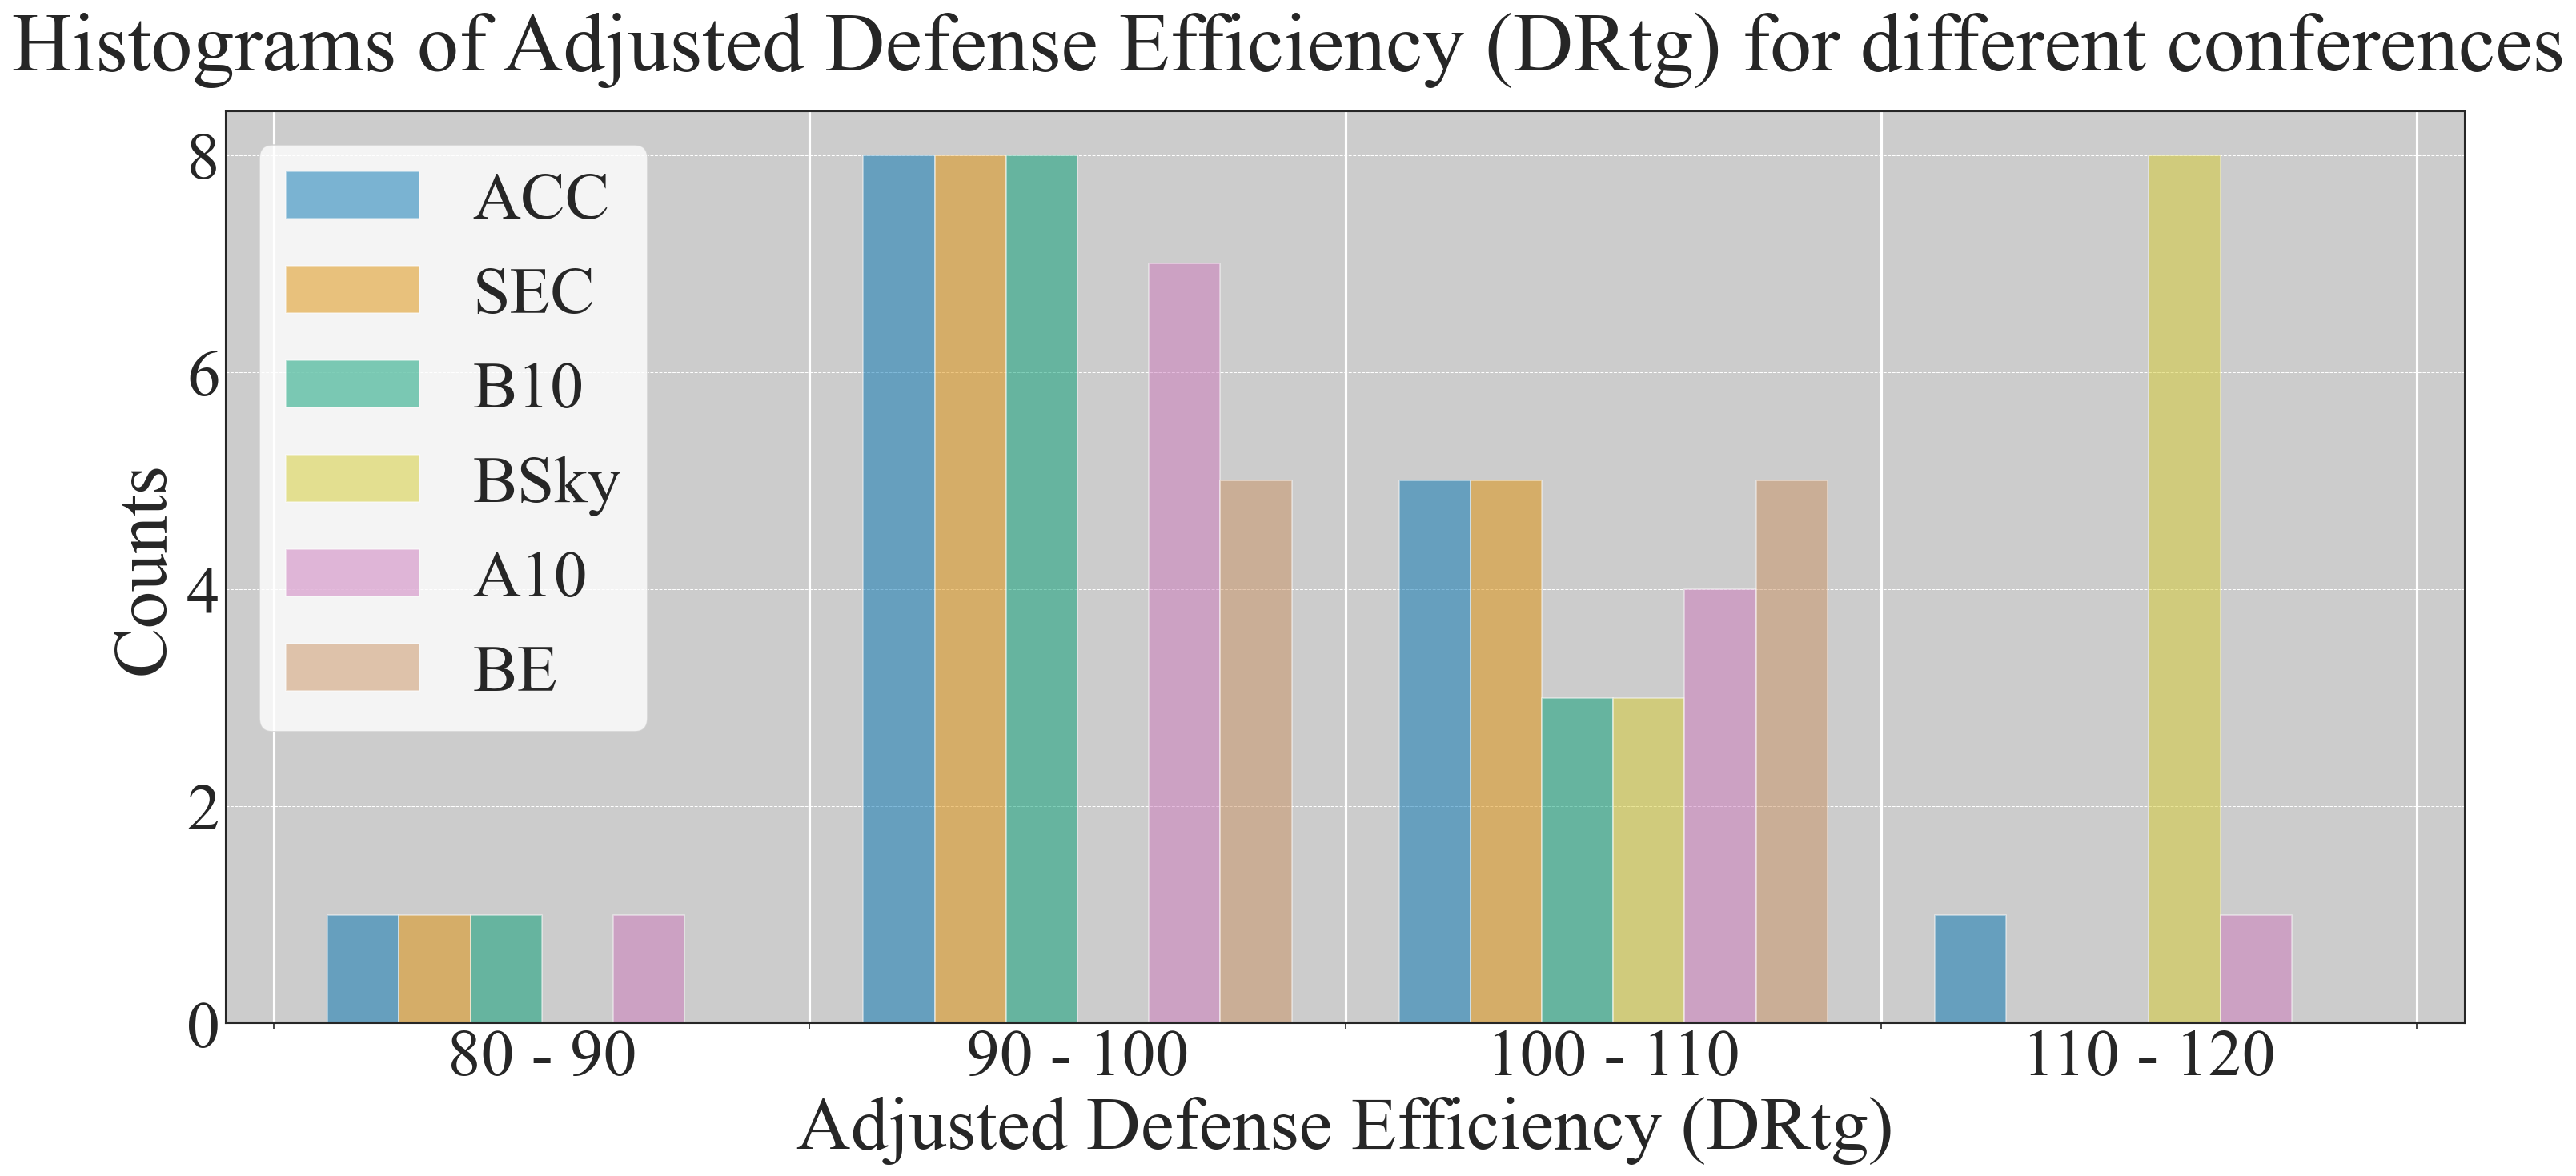

In [442]:
# Creating a new Histogram with the added 'BE' conference
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)

fig_conf, ax_conf = plot_hist(conf_names, bin_arr, hist_range)
plt.savefig('figures/hist2.png', bbox_inches='tight')

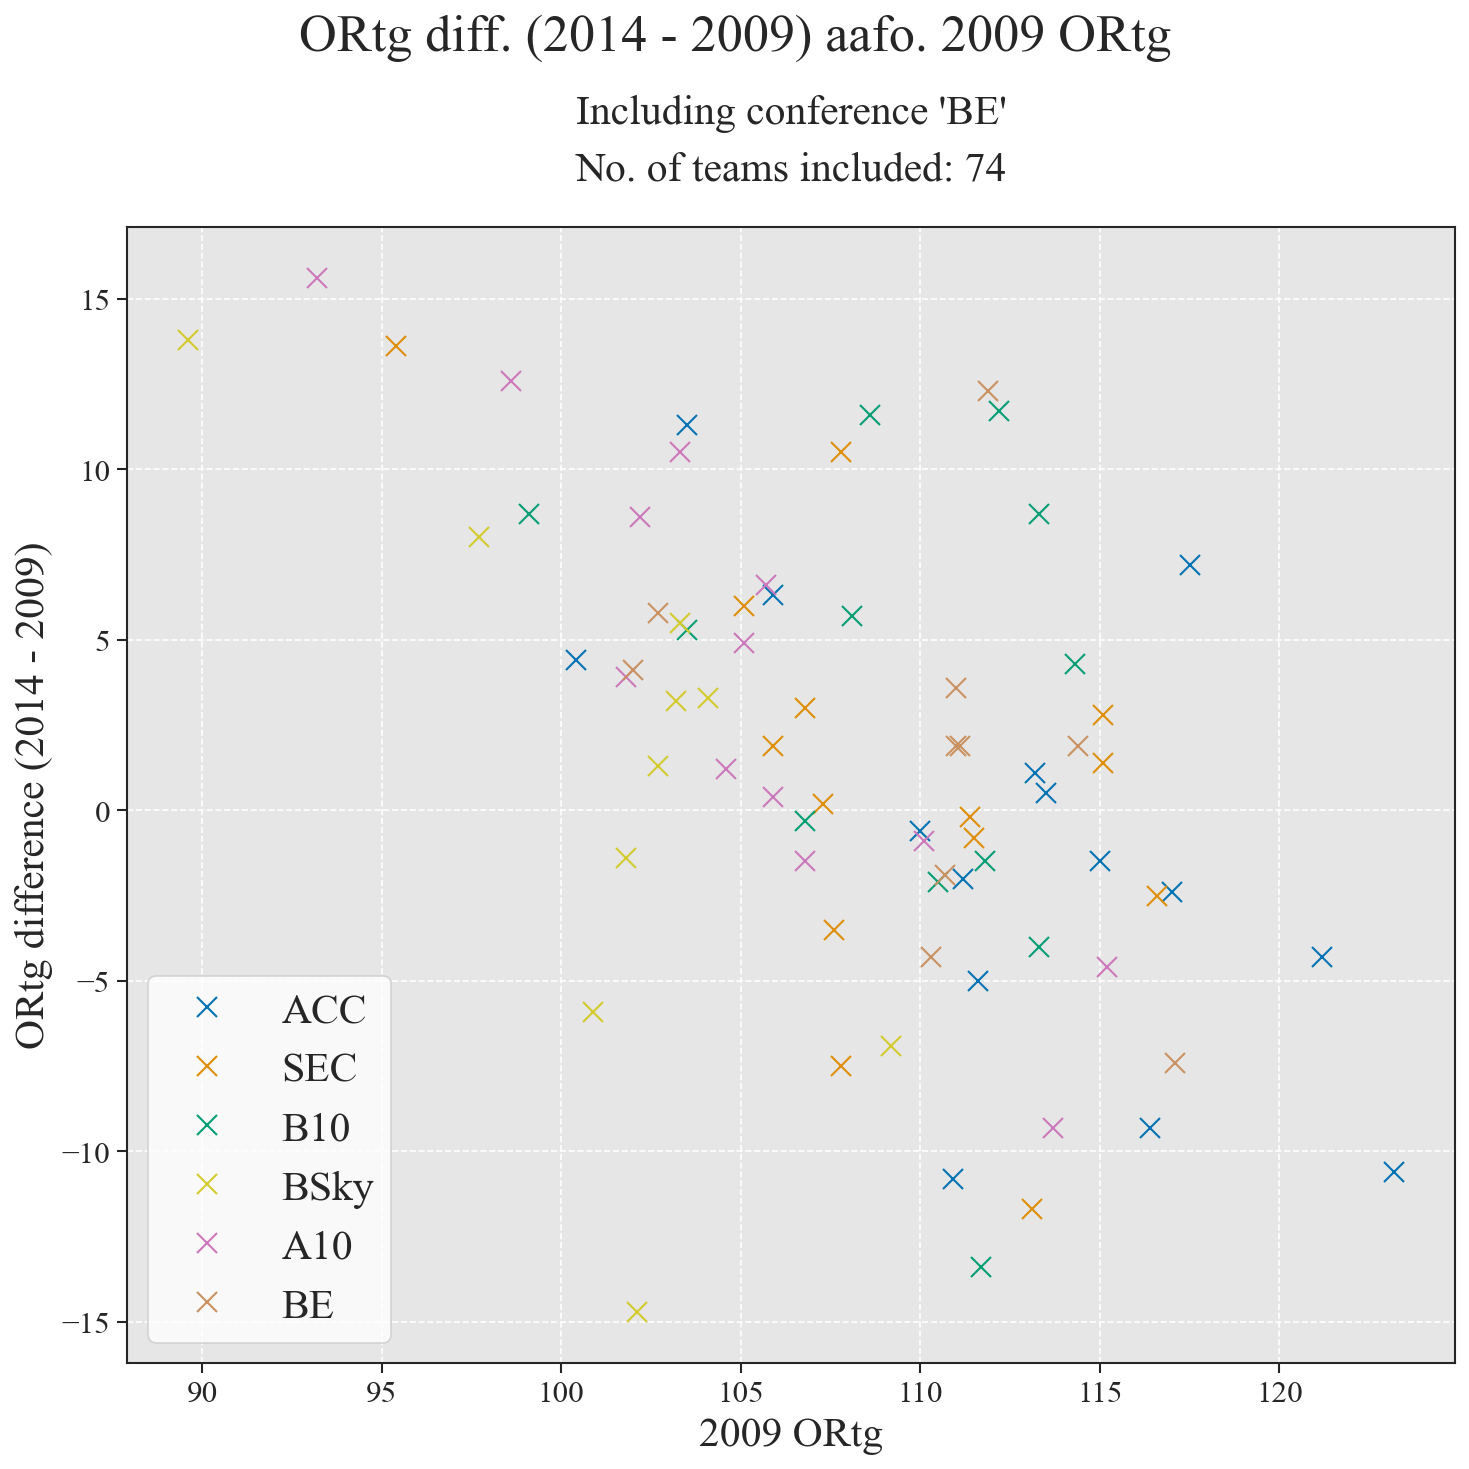

In [443]:
# Calculating and plotting the difference in ORtg with the added 'BE' conference

ortg_diff, ortg_old, non_inc_teams = diff_extractor(conf_names)
fig_diff, ax_diff = diff_plot(conf_names, ortg_diff, ortg_old, inc_text=True)


plt.savefig('figures/diff_plot2.png', bbox_inches='tight')


In [444]:
# Finding median and mean ORtg difference with the included 'BE' conference
conf_diff, non_inc_teams_updated = ortg_data_extr(conf_names, ortg_diff, non_inc_teams)

display(conf_diff)
print(conf_diff.to_latex(index=False))
display(non_inc_teams_updated)
print(non_inc_teams_updated.to_latex(index=False))



/var/folders/8n/5j1kdrfj4snbh52w9b_sq85c0000gn/T/ipykernel_85489/3041330913.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conf_diff = conf_diff._append(new_row, ignore_index=True)


,Conference,# teams,Median ORtg diff,Mean ORtg diff
0,ACC,15,-1.50,-1.05
1,SEC,14,0.80,0.94
2,B10,12,4.80,2.89
3,BSky,10,2.25,0.62
4,A10,13,3.90,3.69
5,BE,10,1.90,1.79
6,Other conf.,268,1.50,2.60


\begin{tabular}{llrr}
\toprule
Conference & # teams & Median ORtg diff & Mean ORtg diff \\
\midrule
ACC & 15 & -1.500000 & -1.050000 \\
SEC & 14 & 0.800000 & 0.940000 \\
B10 & 12 & 4.800000 & 2.890000 \\
BSky & 10 & 2.250000 & 0.620000 \\
A10 & 13 & 3.900000 & 3.690000 \\
BE & 10 & 1.900000 & 1.790000 \\
Other conf. & 268 & 1.500000 & 2.600000 \\
\bottomrule
\end{tabular}



,Conf in 2014,Team Name
0,BSky,North Dakota
1,Other Conf (Sum),Nebraska Omaha
2,Other Conf (WAC),Seattle
3,Other Conf (WAC),Grand Canyon
4,Other Conf (Sum),South Dakota
5,Other Conf (Slnd),Incarnate Word
6,Other Conf (ASun),Northern Kentucky
7,Other Conf (AE),UMass Lowell
8,Other Conf (Slnd),Abilene Christian


\begin{tabular}{ll}
\toprule
Conf in 2014 & Team Name \\
\midrule
BSky & North Dakota \\
Other Conf (Sum) & Nebraska Omaha \\
Other Conf (WAC) & Seattle \\
Other Conf (WAC) & Grand Canyon \\
Other Conf (Sum) & South Dakota \\
Other Conf (Slnd) & Incarnate Word \\
Other Conf (ASun) & Northern Kentucky \\
Other Conf (AE) & UMass Lowell \\
Other Conf (Slnd) & Abilene Christian \\
\bottomrule
\end{tabular}



___
# Extra exercise


In [447]:
import fitz  # PyMuPDF

In [456]:


# Open the PDF
pdf_path = 'extra_exe.pdf'
doc = fitz.open(pdf_path)

# Create and open a .txt file to save the extracted text
with open('output.txt', 'w') as output_file:
    # Loop through the pages and extract text
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text = page.get_text("text")  # Extract raw text from the page
        output_file.write(text + '\n')  # Write text to file


In [534]:
# Read the txt file from line 5 to line 606

with open('output.txt', 'r') as file:
    lines = file.readlines()
    file.close()


unwanted_char = ['¨', '´', '`', ' ']
reg_and = re.compile(r'\sAND\s')

# Extracting the relevant data
names = []
for line in lines[4:607]:
    
    if line[0] == '(' or line[0] == ' ':
        continue

    for word in line.split(','):
        word = word.strip()

        if reg_and.search(word) is not None:
            word = word.replace(' AND ', '')

        for charac in word:
            if not charac.isalpha() and charac != '.':
                word = word.replace(charac, '')

        if word == '':
            continue

        if word[-1] == '.':
            word = word[:-1]


        # Find the last dot in the word
        last_dot = word.rfind('.')
        first_names = word[:last_dot + 1]
        last_name = word[last_dot + 1:]

        new_name= last_name + ' ' + first_names

        names.append(new_name.strip('\n'))




CONSTANCIOJR M.


In [539]:
# Check if any of the names are the same


names = pd.Series(names)
alphabetical_names = names.sort_values()

# Two names in the middle of the list
alpha_len = len(alphabetical_names)
print(alphabetical_names[alpha_len//2 - 1: alpha_len//2 + 1])





duplicates = names[names.duplicated()]
n_dupes = len(duplicates)
n_uniqe = len(names) - n_dupes

quick_df = pd.DataFrame({'Unique names': n_uniqe, 'Duplicate names': n_dupes}, index=[0])
display(quick_df)
print(quick_df.to_latex(index=False))
        

1523      LI B.
1524    LI C.K.
dtype: object


,Unique names,Duplicate names
0,3514,110


\begin{tabular}{rr}
\toprule
Unique names & Duplicate names \\
\midrule
3514 & 110 \\
\bottomrule
\end{tabular}

